In [1]:
import numpy as np
import time
import cv2
from moviepy.editor import VideoClip
from scipy.io import savemat
from os import listdir
from os.path import expanduser
import glob
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib qt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



In [2]:
mov_path = expanduser('~/data/movies/')
mov_format = '.mp4'
movies = glob.glob(mov_path + '*' + mov_format)
movies

['/Users/lmcintosh/data/movies/natural02.mp4',
 '/Users/lmcintosh/data/movies/natural03.mp4']

In [3]:
def rescale_to_uint8(X):
    X -= np.min(X)
    X = X/(np.max(X)/255.)
    return X

In [12]:
? cv2.filter2D

In [32]:
def window(X, dim=(50,50), top_border=0, bottom_border=0, left_border=0, right_border=0, filt=True):
    ''' 
    Crops a window around the center of X and downsamples it to the dimensions specified by dim.
    
    INPUT:
        X     a 2d numpy array
    OUTPUT:
        Y     a 2d numpy array of shape dim
    '''
    H, W = X.shape
    center = [np.int(H/2), np.int(W/2)]
    crop_radius = np.min([np.int(H/2), np.int(W/2)])
    
    # get cropped square center
    X_cropped = X[center[0]-crop_radius+bottom_border:center[0]+crop_radius-top_border, 
                  center[1]-crop_radius+left_border:center[1]+crop_radius-right_border]
    H_cropped, W_cropped = X_cropped.shape
    #assert H_cropped == W_cropped, 'New height and width of window need to match!'
    
    # interpolate cropped square center to appropriate dimensions
    H_sample_rate = H_cropped/dim[0]
    W_sample_rate = W_cropped/dim[1]
    
    if filt:
        kernel = np.ones((H_sample_rate, W_sample_rate), np.float32)/(H_sample_rate * W_sample_rate)
        X_cropped = cv2.filter2D(X_cropped, -1, kernel)
        
    Y = X_cropped[::H_sample_rate, ::W_sample_rate]
    return Y[:dim[0], :dim[1]]

In [33]:
def load_frames(filename, nframes=None, downsample=0, window_flag=False, dim=(50,50), top_border=0,
                bottom_border=0, left_border=0, right_border=0, start_frame=0, exclude_frames=[],
                filt=True):
    ''' 
    Takes a movie file (.mp4, .mov) and returns a numpy array of the frames.
    
    INPUT:
         filename (full path or name of file in cwd)
         nframes (None or number of frames you want)
         downsample (0 to n, each time downsamples in space by 2x)
    '''
    cap = cv2.VideoCapture(filename)
    data_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    if nframes is None:
        nframes = int(data_frames)
    else:
        nframes = int(np.minimum(nframes, cap.get(cv2.CAP_PROP_FRAME_COUNT)))
    width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
    height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fps = cap.get(cv2.CAP_PROP_FPS)
    t = 0
    frames = []
    while(cap.isOpened() and t < nframes):
        ret, frame = cap.read()
        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        for _ in range(downsample):
            # Downsample by 2x per time
            gray = cv2.pyrDown(gray)
#         if frames is None:
#             if window_flag:
#                 frames = np.zeros( (nframes,) + dim, dtype=np.float32)
#             else:
#                 frames = np.zeros( (nframes,) + gray.shape,dtype=np.float32)
        if t >= start_frame and t not in exclude_frames:
            if window_flag:
                frames.append(window(gray, dim=dim, top_border=top_border, bottom_border=bottom_border,
                                     left_border=left_border, right_border=right_border, filt=filt))
            else:
                frames.append(gray)
        t+=1
        if (t+1) % 1000 == 0:
            print '%d / %d' % (t+1, nframes)
    frames = np.array(frames)
    rescaled_frames = rescale_to_uint8(frames)
    return rescaled_frames.astype(np.uint8), fps

In [6]:
# def make_frame(t):
#     """ returns an image of the frame at time t """
#     # ... create the frame with any library
#     return movie_clips[1][t] # (Height x Width x 3) Numpy array

# animation = VideoClip(make_frame, duration=5)

# # For the export, many options/formats/optimizations are supported
# #animation.write_videofile("my_animation.mp4", fps=30) # export as video
# animation.write_gif("my_animation.gif", fps=30, program='ImageMagick') # export as GIF (slow)

In [7]:
# from moviepy.video.VideoClip import DataVideoClip

In [8]:
# times = np.arange(0,33)
# clip = DataVideoClip(times, make_frame, fps=100)
# animation.write_gif("my_animation.gif", fps=30, program='ImageMagick') # export as GIF (slow)

In [9]:
# total_length = 30*60 # in seconds
# desired_fps = 30
# num_movies = 3
# frames_per_movie = int(total_length*desired_fps/num_movies)

In [10]:
# movie_clips = []
# fpss = []
# for movie in listdir(mov_path):
#     full_mov_path = mov_path + movie
#     frames, fps = load_frames(full_mov_path, nframes=frames_per_movie, window_flag=True, border=100, start_frame=500)
#     movie_clips.append(frames)
#     fpss.append(fps)

In [11]:
# for idm, movie in enumerate(movie_clips):
#     filename = 'natural_movie_0%d.mat' %(idm)
#     savemat(filename, mdict={'frames':movie})

# make movies larger

In [34]:
mov3_exclude = np.arange(7200, 9100)
mov3_exclude = np.append(mov3_exclude, np.arange(11250, 25000))

In [35]:
start_frames = [0, 1800]
exclude = [[], mov3_exclude]
movie_clips = []
fpss = []
for idm, movie in enumerate(movies):
    if idm == 0:
        frames, fps = load_frames(movie, window_flag=True, top_border=200, bottom_border=50,
                                  left_border=50, right_border=50,
                                  start_frame=start_frames[idm], dim=(100,100), 
                                  exclude_frames=exclude[idm], filt=True)
    else:
        frames, fps = load_frames(movie, window_flag=True, top_border=50, bottom_border=50,
                                  left_border=50, right_border=50,
                                  start_frame=start_frames[idm], dim=(100,100), 
                                  exclude_frames=exclude[idm], filt=True)
    movie_clips.append(frames)
    fpss.append(fps)

1000 / 16725
2000 / 16725
3000 / 16725
4000 / 16725
5000 / 16725
6000 / 16725
7000 / 16725
8000 / 16725
9000 / 16725
10000 / 16725
11000 / 16725
12000 / 16725
13000 / 16725
14000 / 16725
15000 / 16725
16000 / 16725
1000 / 13165
2000 / 13165
3000 / 13165
4000 / 13165
5000 / 13165
6000 / 13165
7000 / 13165
8000 / 13165
9000 / 13165
10000 / 13165
11000 / 13165
12000 / 13165
13000 / 13165


In [36]:
movie_clips[0].shape

(16725, 100, 100)

In [37]:
movie_clips[1].shape

(7550, 100, 100)

In [38]:
for idm, movie in enumerate(movie_clips):
    filename = 'natural_movie_0%d.mat' %(idm)
    savemat(filename, mdict={'frames':movie})

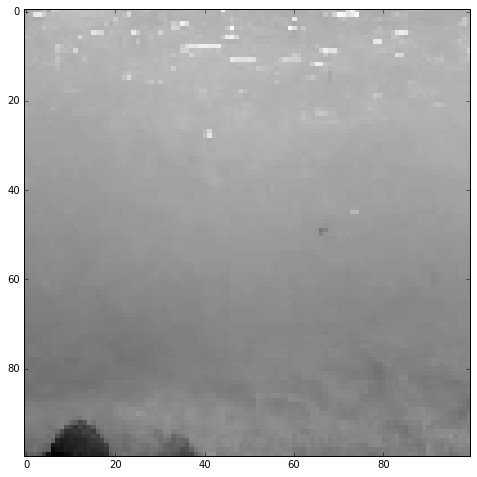

In [21]:
plt.imshow(movie_clips[0][900])

In [24]:
movie_clips[0][900]

array([[155, 155, 157, ..., 155, 155, 155],
       [155, 156, 205, ..., 156, 156, 156],
       [155, 155, 149, ..., 157, 179, 163],
       ..., 
       [121, 120, 123, ..., 136, 136, 135],
       [120, 122, 127, ..., 134, 134, 131],
       [116, 115, 117, ..., 129, 131, 131]], dtype=uint8)

In [24]:
blah = np.ones((50,50))